In [5]:
from utils.scenario_gen import *
from utils.trees import *
from utils.clustering import *
from utils.optimization import *
from utils.simulation import *

from pathlib import Path
import pickle
import hydra
from omegaconf import DictConfig
import os
from pyomo.util.infeasible import log_infeasible_constraints
from pyomo.opt import SolverStatus, TerminationCondition
import logging

In [6]:
# class ClosedLoopSimulation():
#     """
#     Class for closed-loop simulation of the DR optimization problem.
#     """
#     def __init__(self, savepath, simulation_index, optimization_settings, observation_dataclass, scenario_dataclass, idm_scenarioclass, tree_classes=['discharge', 'wl'], simulation_data=None, save_individual_timesteps=False):
#         self.obs = observation_dataclass
#         self.scenario = scenario_dataclass
#         self.idm_scenario = idm_scenarioclass
#         self.control_horizon = 48 # hour
#         self.simulation_index = simulation_index
#         self.idx = pd.IndexSlice
#         self.optimization_settings = optimization_settings
#         self.savepath = savepath
#         self.save_individual_timesteps = save_individual_timesteps
#         self.refit_idm_bn_every = self.optimization_settings['refit_idm_bn_every']

#         self.savepath.mkdir(exist_ok=True)
#         if self.save_individual_timesteps:
#             self.savepath_timesteps = self.savepath / 'timesteps'
#             self.savepath_timesteps.mkdir(exist_ok=True)

#         self.tree_shaped = tree_classes

#         # Initialize simulation data
#         # This will be the dataframe that contains the performed actions.
#         if simulation_data is None: # Start from scratch
#             self.simulation_data = pd.DataFrame(
#                 index=self.simulation_index,
#                 columns=['h_nzk', 'Q_gate', 'Q_pump', 'Q_wb', 'Q_ark', 'E_act', 'E_dam', 'h_ns', 'p_dam', 'p_idm']
#             )
            
#             # Start with a half full reservoir
#             self.simulation_data.loc[self.simulation_data.index[0]-pd.DateOffset(hours=1), 'h_nzk'] = self.optimization_settings['start_wl']
#             self.simulation_data.loc[self.simulation_data.index[0]-pd.DateOffset(hours=1), [col for col in self.simulation_data.columns if col != 'h_nzk']] = 0
#             self.simulation_data = self.simulation_data.sort_index()

#             # Start with initial DAM bid of 0
#             startdate = self.simulation_index.min()
#             idm_index = pd.date_range(startdate, startdate + pd.DateOffset(hours=23-startdate.hour), freq='H')
#             self.simulation_data.loc[idm_index, 'E_dam'] = 0

#         else:
#             self.simulation_data = simulation_data


#     def _get_idm_scenarios(self, t_now):
#         # Get the current DAM prices (observed) untill the next DAM price
#         dam_obs_index = pd.date_range(t_now - pd.DateOffset(hours=t_now.hour + 1), freq='H', periods=25) # 25 because we need the DAM price of the hour before this day as well
#         dam_obs = self.obs.get_observation_data_single('DAM', dam_obs_index[0], dam_obs_index[-1])

#         # Get the IDM scenarios untill now (observed)
#         idm_obs_index = pd.date_range(t_now - pd.DateOffset(hours=t_now.hour + 1), t_now - pd.DateOffset(hours=1), freq='H')
#         idm_obs = self.obs.get_observation_data_single('IDM', idm_obs_index[0], idm_obs_index[-1])
        
#         if self.idm_scenario.method != 'obs':
#             # Get the IDM scenarios untill the DAM (forecast / generated)
#             return self.idm_scenario(dam_obs.values.flatten(), idm_obs.values.flatten(), 10)
#         else:
#             # If observations -> return the observation data
#             idm_scen_index = pd.date_range(idm_obs_index[-1]+pd.DateOffset(hours=1), freq='H', periods=len(dam_obs_index)-len(idm_obs_index))
#             return self.obs.get_observation_data_single('IDM', idm_scen_index[0], idm_scen_index[-1]).values.flatten()


#     def prep_opt_data(self, t_now, inplace=True, return_data=False):
#         """
#         Prepare the optimization data for the optimization problem.
#         This will return the data that is used to calculate the optimal actions.
#         So we return:
#         - the observation at t_now
#         - the IDM scenarios untill the DAM
#         - the DAM scenarios
#         """

#         # Get the observations of the external variables at t_now-1h (so one timestep )
#         t_prev = t_now - pd.DateOffset(hours=1)
#         dam_o, idm_o, wl_hourly_o, discharge_o, ark_o = self.obs.get_observation_data(start=t_prev, end=t_now)

#         # Get the observations of the discharge at ark, this is a perfect forecast.
#         ark_meas = self.obs.get_observation_data_single(var='ARK', start=t_now, end=t_now+pd.DateOffset(hours=self.control_horizon))
        
#         # Get the observations of h_nzk at t_now-1h (so one timestep )
#         # We need to get the h_nzk at t_now-1h, because we need to know the state of the system to decide control actions
#         # So we decide the control action from t_now:t_now+control_horizon
#         h_nzk_o = self.simulation_data.loc[t_prev, 'h_nzk']

#         # Get the IDM scenarios untill the DAM
#         idm_scenarios = self._get_idm_scenarios(t_now).astype(float)
#         if len(idm_scenarios.shape) == 1:
#             idm_scenarios_df = pd.DataFrame(index=[0], columns=range(1, idm_scenarios.shape[0]+2), dtype=float)
#             idm_scenarios_df.iloc[:, :-1] = idm_scenarios
#             idm_scenarios_df.iloc[:, -1] = 1
#             idm_scenarios_df.columns = [i for i in range(1, idm_scenarios.shape[0]+1)] + ['weights']
#             idm_scenarios = idm_scenarios_df
#             idm_scenarios.fillna(1000, inplace=True)

#         # Get the DAM scenarios for tomorrow -> DA bid and prep
#         next_dam_timestep = t_now + pd.DateOffset(hours=24-t_now.hour)
#         dam_scenarios = self.scenario.get_scenarios(next_dam_timestep, 'DAM').copy()
#         # Select the DAM scenarios untill t_now+48h
#         dam_weights = dam_scenarios.iloc[:, [-1]].copy()
#         dam_scenarios = pd.concat([dam_scenarios.iloc[:, [i for i in range(self.control_horizon - (idm_scenarios.shape[1] - 1))]], dam_weights], axis=1).astype(float)

#         # Get the WL scenarios for the next 48 hours
#         wl_scenarios = self.scenario.get_scenarios(t_now, 'wl').copy()
#         wl_scenarios.iloc[:, :-1] = wl_scenarios.iloc[:, :-1] / 100 # cm+NAP to m+NAP

#         # Get the discharge scenarios for the next 48 hours
#         discharge_scenarios = self.scenario.get_scenarios(t_now, 'discharge').copy()

#         optimization_data = {}
#         optimization_data['dam'] = {}
#         optimization_data['idm'] = {}
#         optimization_data['wl'] = {}
#         optimization_data['wb_discharge'] = {}
#         optimization_data['h_nzk'] = {}
#         optimization_data['ark_discharge'] = {}
#         optimization_data['probabilities'] = {}
#         optimization_data['E_dam'] = {}
        
#         optimization_data['h_nzk'][-1] = h_nzk_o # Both are the last calculated, so t-1h!
#         optimization_data['h_nzk'][0] = h_nzk_o

#         optimization_data['dam'][-1] = dam_o.values[0].round(2)
#         optimization_data['dam'][0] = dam_o.values[1].round(2)
#         optimization_data['idm'][-1] = idm_o.values[0].round(2)
#         optimization_data['idm'][0] = idm_o.values[1].round(2)
#         optimization_data['wl'][-1] = wl_hourly_o.values[0].round(3)[0]
#         optimization_data['wl'][0] = wl_hourly_o.values[1].round(3)[0]
        
#         optimization_data['wb_discharge'][-1] = discharge_o.values[0].round(2)
#         optimization_data['wb_discharge'][0] = discharge_o.values[1].round(2)
#         optimization_data['ark_discharge'][-1] = ark_o.values[0].round(2)
#         optimization_data['ark_discharge'][0] = ark_o.values[1].round(2)

#         n_id_timesteps = len(idm_scenarios.columns) - 1 # -1 since weights are in DF
#         # Intraday trading
#         for t_id in range(1,  n_id_timesteps+1): 
#             optimization_data['dam'][t_id] = np.nan
#             optimization_data['idm'][t_id] = idm_scenarios.iloc[:, t_id-1].values.round(2)
#             optimization_data['ark_discharge'][t_id] = ark_meas.iloc[t_id-1].values.round(2)
#             if 'discharge' not in self.tree_shaped:
#                 optimization_data['wb_discharge'][t_id] = discharge_scenarios.iloc[:, t_id-1].values.round(2)
#             if 'wl' not in self.tree_shaped:
#                 optimization_data['wl'][t_id] = wl_scenarios.iloc[:, t_id-1].values.round(3)

#             # Get the DAM bid made for the ID trading period
#             optimization_data['E_dam'][t_id] = self.simulation_data.loc[t_now + pd.DateOffset(hours=t_id-1), 'E_dam']

#         # DA trading
#         for t in range(n_id_timesteps+1, self.control_horizon+1):
#             optimization_data['dam'][t] = dam_scenarios.iloc[:, t-n_id_timesteps-1].values.round(2)
#             optimization_data['idm'][t] = np.nan # NO multistage IDM yet
#             optimization_data['ark_discharge'][t] = ark_meas.iloc[t-1].values.round(2)
#             if 'discharge' not in self.tree_shaped:
#                 optimization_data['wb_discharge'][t] = discharge_scenarios.iloc[:, t-1].values.round(2)
#             if 'wl' not in self.tree_shaped:
#                 optimization_data['wl'][t] = wl_scenarios.iloc[:, t-1].values.round(2)
#             optimization_data['E_dam'][t] = np.nan
        
#         optimization_data['probabilities']['dam'] = dam_scenarios.iloc[:, -1].values.round(3)
#         optimization_data['probabilities']['idm'] = idm_scenarios.iloc[:, -1].values.round(3)

#         if 'discharge' in self.tree_shaped:
#             optimization_data['wb_discharge'][1] = self.scenario.generate_tree(t_now, 'discharge', scenarios=discharge_scenarios)
#         else:
#             optimization_data['probabilities']['wb_discharge'] = discharge_scenarios.iloc[:, -1].values.round(3)
        
#         if 'wl' in self.tree_shaped:
#             optimization_data['wl'][1] = self.scenario.generate_tree(t_now, 'wl', scenarios=wl_scenarios)
#         else:
#             optimization_data['probabilities']['wl'] = wl_scenarios.iloc[:, -1].values.round(3)

#         if inplace:
#             self.optimization_data = optimization_data
#         if return_data:
#             return optimization_data
    
#     def optimize(self, t_now):
#         """
#         Optimize the control actions for the next 48 hours.
#         """
#         solved=False
#         i=0
#         while not solved:
#             self.prep_opt_data(t_now, inplace=True, return_data=False)
#             logfile = str((self.savepath_timesteps / f'{t_now.strftime("%Y-%m-%d %H")}.log').resolve())
#             problem = NZKProblem(
#                 optimization_data=self.optimization_data,
#                 optimization_settings=self.optimization_settings,
#                 pred_hor=self.control_horizon,
#                 tree_classes=self.tree_shaped,
#                 logfile=logfile
#             )
#             problem.make_model()
#             model = problem.solve(verbose=False)

#             if problem.opt_results.solver.status == SolverStatus.ok:
#                 solved=True
#             elif problem.opt_results.solver.termination_condition != TerminationCondition.infeasible:
#                 solved=True
#             else:
#                 i+=1
#                 print(f'Infeasible optimization problem nr {i}, trying again with different scenarios')
#             if i > 10:
#                 raise ValueError('Infeasible optimization problem, tried 10 times with different scenarios')
        
#         results = problem.get_results(model)
#         if self.save_individual_timesteps:
#             with open(self.savepath_timesteps / f'{t_now.strftime("%Y-%m-%d %H")}.pkl', 'wb') as f:
#                 pickle.dump(results, f)

#         return results
    
#     def _correct_q_gate(self, q, dh):
#         N=7 # kokers
#         B=5.9 # m
#         a=1.0 # coefficient
#         H=4.8 #m keelhoogte
#         g=9.81 # m/s^2
#         q_max = N*a*B*H* np.sqrt(2*g*dh)
#         return np.round(min(q, q_max), decimals=2)
    
#     def _correct_q_pump(self, q, dh):
#         a = -3.976
#         b = -17.7244
#         c = 269.58
#         q_max = a*dh**2 + b*dh + c
#         return np.round(min(q, q_max), decimals=2)

#     def pump_energy(self, q, dh, dt=3600):
#         return (0.033*q**2 + 0.061*dh**2*q + 11.306*dh*q) * dt / 3600 / 1000 # MWh
    
#     def calculate_expected_energy(self, timestep_index, results, dt=3600):
#         """
#         Calculate the expected energy use over all scenarios.
#         Timestep index is the index of optimization timestep (so [1,48])
#         """
#         E_exp = 0
#         for node in results:
#             if timestep_index in node.domain:
#                 node_timestep_index = node.domain.index(timestep_index)
#                 q_pump = node.results['q_pump'][node_timestep_index]
#                 h_nzk = node.results['h_nzk'][node_timestep_index]

#                 wl_node_timestep_index = node.wl_node.domain.index(timestep_index)
#                 wl_ns = node.wl_node.values[wl_node_timestep_index]
                
#                 dh = max(wl_ns - h_nzk, 0)
#                 q_pump = self._correct_q_pump(q_pump, dh)
#                 E_exp += node.p_marginal * self.pump_energy(q_pump, dh, dt)
#         return E_exp

#     def simulate_timestep(self, t_now, results):
#         """
#         Simulate the next timestep.
#         """
#         # Get the observations of the external variables at t_now-1h (so one timestep)
#         wl_ns = np.round(self.optimization_data['wl'][0], decimals=3) # accuracy in mm
#         h_nzk0 = self.optimization_data['h_nzk'][0] # accuracy in mm
#         q_wb = np.round(self.optimization_data['wb_discharge'][0], decimals=2)[0]
#         q_ark = np.round(self.optimization_data['ark_discharge'][0], decimals=2)[0]
#         dh_gate = max(h_nzk0 - wl_ns, 0)
#         dh_pump = max(wl_ns - h_nzk0, 0)

#         # Get the actions (Q_gate, Q_pump) from the optimization results, correct them for the physical limitations.
#         q_gate = self._correct_q_gate(results[0].results['q_gate'][0], dh_gate)
#         q_pump = self._correct_q_pump(results[0].results['q_pump'][0], dh_pump)
        
#         # Calculate the next water level
#         A_nzk = 36*10e6 # m^2
#         dt = 3600 # s
#         q_out = q_gate + q_pump
#         q_in = q_wb + q_ark
#         h_nzk1 = np.round(h_nzk0 + (q_in - q_out) * dt / A_nzk, decimals=4)
#         E_act = self.pump_energy(q_pump, dh_pump, dt) # MWh

#         self.simulation_data.loc[t_now, 'h_nzk'] = h_nzk1
#         self.simulation_data.loc[t_now, 'Q_gate'] = q_gate
#         self.simulation_data.loc[t_now, 'Q_pump'] = q_pump
#         self.simulation_data.loc[t_now, 'Q_wb'] = q_wb
#         self.simulation_data.loc[t_now, 'Q_ark'] = q_ark
#         self.simulation_data.loc[t_now, 'E_act'] = E_act
#         self.simulation_data.loc[t_now, 'h_ns'] = wl_ns
#         self.simulation_data.loc[t_now, 'p_dam'] = self.optimization_data['dam'][0].flatten()[0]
#         self.simulation_data.loc[t_now, 'p_idm'] = self.optimization_data['idm'][0].flatten()[0]

#         if t_now.hour == 11:
#             # Make a DAM bid at 11:00 AM for the next day (00:00 - 24:00)
#             # We bid the expected energy use over all scenarios
#             dam_start = 24 - t_now.hour 
#             for t in range(dam_start, dam_start + 24):
#                 self.simulation_data.loc[t_now + pd.DateOffset(hours=t), 'E_dam'] = self.calculate_expected_energy(t+1, results, dt) # +1 because time starts at 1 in the optimization problem
    
#     def check_refit_bn(self, t_now):
#         if self.optimization_settings['distance'] != 'obs':
#             if t_now - self.idm_scenario.t_max > pd.Timedelta(value=self.refit_idm_bn_every, unit='hours'):
#                 print('Refitting IDM BN')
#                 self.idm_scenario.update_bn(t_min=t_now-pd.DateOffset(days=365), t_max=t_now)

#     def fit_bn_until(self, t_now):
#         i=0
#         while self.simulation_data.index[1] + pd.DateOffset(hours=i*self.refit_idm_bn_every) < t_now:
#             i += 1
#         t_refit = self.simulation_data.index[1] + pd.DateOffset(hours=(i-1)*self.refit_idm_bn_every)
#         self.check_refit_bn(t_refit)


#     def run_simulation(self, save_every=1):
#         t0 = self.simulation_data.loc[self.simulation_data.isna().any(axis=1)].index.min()
#         print('Running simulation from', t0)
#         self.fit_bn_until(t0)
        
#         for i, date in enumerate(tqdm(self.simulation_data.loc[t0:].index)):
#             if i % save_every == 0:
#                 # self.simulation_data.to_csv(self.savepath / 'simulation_data.csv')
#                 self.simulation_data.to_pickle(self.savepath / 'simulation_data.pkl')
#             results = self.optimize(date)
#             self.simulate_timestep(date, results)
#             self.check_refit_bn(date)
#         self.simulation_data.to_pickle(self.savepath / 'simulation_data.pkl')

# def make_exp_name(optimization_settings):
#     exp_name = optimization_settings['wl_constraint_type']
#     if exp_name == 'cvar':
#         exp_name += f'_{optimization_settings["cvar_alpha"]}'
#         exp_name += f'_{abs(optimization_settings["cvar_wl"])}'
#     elif exp_name == 'chance':
#         exp_name += f'_{optimization_settings["p_chance"]}'
#     elif exp_name == 'robust':
#         pass
#     else:
#         raise NotImplementedError('Only implemented for cvar, chance and rosbut')
#     exp_name += f'_{optimization_settings["distance"]}'
#     exp_name += f'_{optimization_settings["n_scenarios"]}'
#     if optimization_settings['tree']:
#         exp_name += '_tree'
#     else:
#         exp_name += '_fan'
#     if optimization_settings["distance"] == 'obs':
#         exp_name = 'obs'
#     return exp_name

In [7]:
datapath = datapath = Path(Path().resolve()).parent.parent.parent / 'data'
datapath

WindowsPath('D:/Users/Heijden/Documents/PhD work/Current work/DR_IJmuiden/data')

In [8]:

scenario_path = datapath / 'forecast data' / 'Scenarios'
market_datapath = datapath / 'market data'
wl_datapath = datapath / 'waterlevel data'
wb_datapath = datapath / 'waterboard data'
ark_datapath = datapath / 'ark data'


optimization_datapath = datapath / 'optimization data' / 'timeseries simulation'


n_root_steps = 3
n_scenarios = 1

n_q_scenarios = n_scenarios
n_dam_scenarios = n_scenarios
n_idm_scenarios = n_scenarios
n_wl_scenarios = n_scenarios

if (n_q_scenarios <= 3):
    n_wb_scenarios = 3
else:
    n_wb_scenarios = n_q_scenarios

distance_metric = 'energy'
scenario_params = {
    'DAM': {
        'n': n_dam_scenarios,
        'method': distance_metric,
    },
    'IDM':{
        'n_init': 100,
        'n': n_idm_scenarios,
        'method': distance_metric,
    },
    'wl': {
        'n': n_wl_scenarios,
        'method': distance_metric,
    },
    'discharge': {
        'n': n_q_scenarios,
        'n_wb': n_wb_scenarios,
        'method': distance_metric
    },
    'n_root_steps': n_root_steps
}


obs_data = ObservationData(market_datapath, wl_datapath, wb_datapath, ark_datapath)
idm_scenarios = IDMScenarios(
    obs_dataclass=obs_data,
    n_init=scenario_params['IDM']['n_init'],
    n=scenario_params['IDM']['n'],
    method=scenario_params['IDM']['method'],
    cluster=True,
)
t_min = idm_scenarios.dam.index.min()
idm_scenarios.update_bn(t_min=t_min, t_max=t_min + pd.DateOffset(days=365))


scenario_data = ScenarioData(
    scenario_params=scenario_params,
    scenario_path=scenario_path,
    constrain_tree_complexity=True,
    complexity_reduction=0.5,
)


In [9]:
scenario_data.dam[290:]

,,DAM NL +1,DAM NL +2,DAM NL +3,DAM NL +4,DAM NL +5,DAM NL +6,DAM NL +7,DAM NL +8,DAM NL +9,DAM NL +10,...,DAM NL +40,DAM NL +41,DAM NL +42,DAM NL +43,DAM NL +44,DAM NL +45,DAM NL +46,DAM NL +47,DAM NL +48,weights
date,scenario,,,,,,,,,,,,,,,,,,,,,
2019-10-19 00:00:00+02:00,0,35.64,33.80,32.98,32.00,30.50,31.35,32.38,33.21,34.03,33.01,...,46.57,49.82,51.70,51.94,53.53,48.72,41.69,36.88,37.85,1.0
2019-10-20 00:00:00+02:00,0,31.12,26.70,25.45,26.63,27.46,33.05,39.32,43.60,44.93,46.20,...,38.06,42.24,45.50,48.27,46.40,42.26,39.37,38.31,39.36,1.0
2019-10-21 00:00:00+02:00,0,31.93,31.54,32.93,34.70,34.45,40.18,45.78,51.76,54.35,49.57,...,37.36,41.26,47.65,49.54,44.00,40.66,39.50,37.05,37.27,1.0
2019-10-22 00:00:00+02:00,0,38.58,34.31,33.54,32.97,33.48,36.15,42.75,49.94,51.53,49.32,...,35.38,39.36,46.61,44.68,46.42,41.86,39.22,38.76,37.32,1.0
2019-10-23 00:00:00+02:00,0,34.71,34.76,31.90,33.44,35.03,38.53,43.60,46.46,51.78,50.00,...,34.70,38.39,40.95,41.05,48.60,40.49,37.55,37.19,38.96,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-26 00:00:00+01:00,0,48.15,47.36,42.73,44.63,43.18,42.12,49.88,60.60,63.20,65.46,...,49.31,53.44,59.14,62.98,62.10,56.61,49.31,48.98,48.50,1.0
2021-01-27 00:00:00+01:00,0,41.37,40.13,40.90,37.92,37.78,39.85,47.06,54.92,60.70,62.31,...,45.09,45.87,53.04,57.08,52.62,52.44,46.28,46.99,44.31,1.0
2021-01-28 00:00:00+01:00,0,40.99,41.22,35.93,35.01,34.08,36.82,40.59,49.42,55.13,55.39,...,45.01,49.14,56.48,57.87,58.87,53.97,45.56,46.13,44.35,1.0


In [10]:

optimization_settings = {
    'wl_constraint_type': 'robust',#'cvar',
    'var_wl': -0.4,
    'cvar_wl': -0.395,
    'cvar_alpha': 0.99,
    'p_chance': 0.1,
    'obj_type': 'expected_value',
    'refit_idm_bn_every': 7*24, # every week
    'start_wl': -0.45, # m+NAP
    'distance': distance_metric,
    'n_scenarios': n_scenarios,
    'tree': False,
    'year': 2019,
    'h_max': -0.4,
}


In [11]:
# t_now = obs_data.dam.index[11] + pd.DateOffset(years=1, days=0)
# t_now

In [12]:
year=2021
month=1
optimization_datapath_exp = optimization_datapath / 'low' / f'{year}-{month}'
start_new=False

t_now = obs_data.dam.loc[(obs_data.dam.index.year==year) & (obs_data.dam.index.month==month)].index.min() + pd.DateOffset(hours=11) # Start at 11am
# t_now = obs_data.dam.index[11] + pd.DateOffset(years=1, days=0) # Misschien in maart beginnen? Of iig deels? Die was vrij nat.

# simulation_index = pd.date_range(t_now, t_now + pd.DateOffset(days=30, hours=12), freq='H')
simulation_index = pd.date_range(t_now, t_now + pd.DateOffset(months=1, hours=-25), freq='H') # End at 23pm at the last day of the month
exp_name = make_exp_name(optimization_settings)

In [16]:
simulation_data = None
if optimization_settings['tree']:
    tree_classes = ['discharge', 'wl']
else:
    tree_classes = []


In [ ]:

if start_new:
    simulation_data = None
else:
    simulation_data = pd.read_pickle(optimization_datapath_exp / exp_name / 'simulation_data.pkl')
    # simulation_data.dropna(how='all')
    t_now = simulation_data.loc[simulation_data.isna().any(axis=1)].index.min()

if optimization_settings['tree']:
    tree_classes = ['discharge', 'wl']
else:
    tree_classes = []

In [ ]:
# t_now = simulation_data.loc[simulation_data.isna().any(axis=1)].index.min()# - pd.DateOffset(hours=1)
# t_now

In [ ]:
simulation_data.iloc[610:]

AttributeError: 'NoneType' object has no attribute 'iloc'

In [ ]:
simulation_data.dropna(how='all')

,h_nzk,Q_gate,Q_pump,Q_wb,Q_ark,E_act,E_dam,h_ns,p_dam,p_idm
2019-10-01 10:00:00+02:00,-0.45,0,0,0,0,0,0,0,0,0
2019-10-01 11:00:00+02:00,-0.4482,0.0,0.0,137.78,42.2,0.0,0,0.527,44.92,NaN
2019-10-01 12:00:00+02:00,-0.4466,0.0,0.0,126.16,38.02,0.0,0,0.425,42.17,NaN
2019-10-01 13:00:00+02:00,-0.4453,0.0,32.97,124.84,35.35,0.20949,0,0.018,41.04,NaN
2019-10-01 14:00:00+02:00,-0.4434,0.0,0.0,161.15,30.52,0.0,0,-0.313,39.49,NaN
...,...,...,...,...,...,...,...,...,...,...
2019-10-27 18:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,0.143647,NaN,NaN,NaN
2019-10-27 19:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,0.190828,NaN,NaN,NaN
2019-10-27 20:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,0.356482,NaN,NaN,NaN
2019-10-27 21:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,0.128953,NaN,NaN,NaN


In [ ]:
# t_now = t_now - pd.DateOffset(hours=2)
t_now = simulation_data.loc[simulation_data.Q_gate.isna()].index.min()
t_now

Timestamp('2019-10-27 00:00:00+0200', tz='Europe/Amsterdam')

In [14]:
t_now = obs_data.dam.loc[(obs_data.dam.index.year==year) & (obs_data.dam.index.month==month)].index.min() + pd.DateOffset(days=30) # Start at 11am

t_now

Timestamp('2021-01-31 00:00:00+0100', tz='Europe/Amsterdam')

In [17]:
simulator = ClosedLoopSimulation(
    savepath=optimization_datapath / exp_name,
    optimization_settings=optimization_settings,
    simulation_index=simulation_index,
    observation_dataclass=obs_data,
    scenario_dataclass=scenario_data,
    idm_scenarioclass=idm_scenarios,
    save_individual_timesteps=True,
    simulation_data=simulation_data,
    tree_classes=tree_classes
)
simulator.fit_bn_until(t_now)

Refitting IDM BN


In [15]:
# simulator.run_simulation()

In [16]:
# t_now -= pd.DateOffset(hours=1)

In [20]:
simulator.scenario.dam

,,DAM NL +1,DAM NL +2,DAM NL +3,DAM NL +4,DAM NL +5,DAM NL +6,DAM NL +7,DAM NL +8,DAM NL +9,DAM NL +10,...,DAM NL +40,DAM NL +41,DAM NL +42,DAM NL +43,DAM NL +44,DAM NL +45,DAM NL +46,DAM NL +47,DAM NL +48,weights
date,scenario,,,,,,,,,,,,,,,,,,,,,
2019-01-02 00:00:00+01:00,0,53.81,51.90,47.93,52.36,53.54,51.73,62.54,68.47,74.05,75.06,...,50.09,52.38,73.13,68.71,63.41,52.56,54.48,51.64,55.88,1.0
2019-01-03 00:00:00+01:00,0,51.91,49.81,47.86,44.41,45.68,47.71,61.10,70.54,75.49,72.75,...,64.70,67.11,76.89,77.90,76.63,72.31,68.66,64.76,55.85,1.0
2019-01-04 00:00:00+01:00,0,49.77,45.54,44.47,45.44,44.87,46.02,45.72,66.70,61.92,66.63,...,60.19,60.45,68.33,67.95,60.13,62.83,61.47,53.11,47.60,1.0
2019-01-05 00:00:00+01:00,0,51.96,47.06,48.44,46.98,49.36,52.18,56.85,65.07,70.35,70.30,...,57.64,56.08,71.00,65.30,57.58,52.44,47.97,47.84,45.63,1.0
2019-01-06 00:00:00+01:00,0,42.98,43.71,39.69,44.72,45.29,49.03,61.51,69.61,64.83,65.61,...,57.08,60.34,79.09,67.27,68.51,52.18,51.92,53.72,48.37,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-26 00:00:00+01:00,0,48.15,47.36,42.73,44.63,43.18,42.12,49.88,60.60,63.20,65.46,...,49.31,53.44,59.14,62.98,62.10,56.61,49.31,48.98,48.50,1.0
2021-01-27 00:00:00+01:00,0,41.37,40.13,40.90,37.92,37.78,39.85,47.06,54.92,60.70,62.31,...,45.09,45.87,53.04,57.08,52.62,52.44,46.28,46.99,44.31,1.0
2021-01-28 00:00:00+01:00,0,40.99,41.22,35.93,35.01,34.08,36.82,40.59,49.42,55.13,55.39,...,45.01,49.14,56.48,57.87,58.87,53.97,45.56,46.13,44.35,1.0


In [17]:
# t_now + pd.DateOffset(hours=24-t_now.hour + 1)
t_now

Timestamp('2019-10-27 00:00:00+0200', tz='Europe/Amsterdam')

In [18]:
data_dict = simulator.prep_opt_data(t_now, inplace=True, return_data=True)

DatetimeIndex(['2021-01-30 23:00:00+01:00', '2021-01-31 00:00:00+01:00',
               '2021-01-31 01:00:00+01:00', '2021-01-31 02:00:00+01:00',
               '2021-01-31 03:00:00+01:00', '2021-01-31 04:00:00+01:00',
               '2021-01-31 05:00:00+01:00', '2021-01-31 06:00:00+01:00',
               '2021-01-31 07:00:00+01:00', '2021-01-31 08:00:00+01:00',
               '2021-01-31 09:00:00+01:00', '2021-01-31 10:00:00+01:00',
               '2021-01-31 11:00:00+01:00', '2021-01-31 12:00:00+01:00',
               '2021-01-31 13:00:00+01:00', '2021-01-31 14:00:00+01:00',
               '2021-01-31 15:00:00+01:00', '2021-01-31 16:00:00+01:00',
               '2021-01-31 17:00:00+01:00', '2021-01-31 18:00:00+01:00',
               '2021-01-31 19:00:00+01:00', '2021-01-31 20:00:00+01:00',
               '2021-01-31 21:00:00+01:00', '2021-01-31 22:00:00+01:00',
               '2021-01-31 23:00:00+01:00'],
              dtype='datetime64[ns, Europe/Amsterdam]', freq='H')
DatetimeIndex

KeyError: Timestamp('2021-02-01 00:00:00+0100', tz='Europe/Amsterdam')

In [48]:
data_dict.keys()

dict_keys(['dam', 'idm', 'wl', 'wb_discharge', 'h_nzk', 'ark_discharge', 'probabilities', 'E_dam'])

In [49]:
vals = [data_dict['ark_discharge'][k] for k in data_dict['ark_discharge'].keys()]
print(vals)
print(len(vals))

[array([9.01]), array([5.34]), array([5.34]), array([-14.3]), array([-23.88]), array([-11.65]), array([18.23]), array([29.99]), array([49.85]), array([51.37]), array([48.47]), array([39.71]), array([22.92]), array([11.78]), array([-1.2]), array([14.44]), array([31.57]), array([43.64]), array([27.64]), array([28.68]), array([8.64]), array([6.71]), array([13.94]), array([1.9]), array([9.35]), array([13.38]), array([24.32]), array([13.47]), array([12.32]), array([6.72]), array([12.24]), array([8.02]), array([17.55]), array([23.92]), array([30.4]), array([33.32]), array([30.19]), array([31.85]), array([20.75]), array([30.42]), array([14.35]), array([6.77]), array([3.11]), array([23.66]), array([14.3]), array([24.54]), array([25.75]), array([18.14]), array([17.24]), array([11.27])]
50


In [50]:
vals = [data_dict['dam'][k] for k in data_dict['dam'].keys() if data_dict['dam'][k] is not np.nan]
print(vals)
print(len(vals))

[array([26.81]), array([32.21]), array([33.4]), array([31.16]), array([34.19]), array([34.13]), array([33.83]), array([42.71]), array([46.6]), array([52.09]), array([53.67]), array([55.31]), array([49.17]), array([43.87]), array([42.5]), array([44.18]), array([43.35]), array([46.78]), array([52.73]), array([59.69]), array([50.42]), array([51.79]), array([44.31]), array([38.34]), array([37.38]), array([35.46])]
26


In [51]:
vals = [data_dict['idm'][k] for k in data_dict['idm'].keys() if data_dict['idm'][k] is not np.nan]
print(vals)
print(len(vals))

[array([39.13]), array([32.]), array([51.18]), array([43.81]), array([43.21]), array([82.86]), array([44.35]), array([29.68]), array([35.76]), array([40.2]), array([54.71]), array([50.58]), array([57.16]), array([66.07]), array([59.4]), array([62.77]), array([68.97]), array([71.34]), array([95.22]), array([72.87]), array([80.74]), array([80.34]), array([71.27]), array([64.19]), array([64.75]), array([50.15])]
26


In [23]:
vals = [data_dict['wl'][k] for k in data_dict['wl'].keys()]
print(vals)
print(len(vals))

[-0.122, -0.2, array([-0.11]), array([0.332]), array([1.093]), array([1.326]), array([1.154]), array([0.952]), array([0.724]), array([0.546]), array([0.323]), array([0.03]), array([-0.186]), array([-0.405]), array([-0.383]), array([-0.326]), array([0.252]), array([0.965]), array([0.87]), array([0.707]), array([0.212]), array([0.057]), array([-0.06]), array([0.042]), array([-0.341]), array([-0.658]), array([-0.73]), array([-0.57]), array([0.04]), array([0.83]), array([1.15]), array([1.09]), array([0.55]), array([0.37]), array([0.29]), array([0.11]), array([-0.12]), array([-0.34]), array([-0.64]), array([-0.67]), array([-0.54]), array([0.36]), array([0.93]), array([0.84]), array([0.45]), array([0.09]), array([-0.]), array([0.03]), array([-0.09]), array([-0.41])]
50


In [24]:
vals = [data_dict['wb_discharge'][k] for k in data_dict['wb_discharge'].keys()]
print(vals)
print(len(vals))

[array([56.87]), array([59.72]), array([61.87]), array([65.22]), array([62.08]), array([64.74]), array([57.98]), array([57.31]), array([39.1]), array([32.02]), array([31.41]), array([31.65]), array([33.99]), array([22.22]), array([28.53]), array([20.63]), array([25.66]), array([24.61]), array([23.53]), array([17.19]), array([18.79]), array([31.79]), array([28.92]), array([37.44]), array([37.77]), array([36.32]), array([39.62]), array([36.67]), array([44.63]), array([42.79]), array([46.08]), array([53.57]), array([42.08]), array([34.19]), array([30.45]), array([26.75]), array([48.68]), array([35.54]), array([32.82]), array([37.1]), array([31.82]), array([19.43]), array([17.48]), array([22.51]), array([15.38]), array([12.54]), array([11.71]), array([17.7]), array([26.78]), array([43.89])]
50


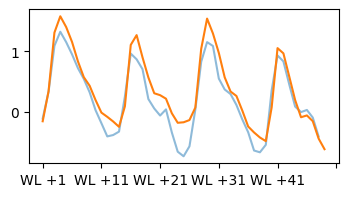

In [25]:
fig, ax = plt.subplots(figsize=(4,2))
wl_scenarios = simulator.scenario.get_scenarios(t_now, 'wl').copy()
(wl_scenarios.iloc[:,:-1].T / 100).plot(legend=False, alpha=0.5, ax=ax)
ax.plot(range(0,49), obs_data.wl_hourly.shift(-1).loc[t_now:t_now+pd.DateOffset(hours=48)])

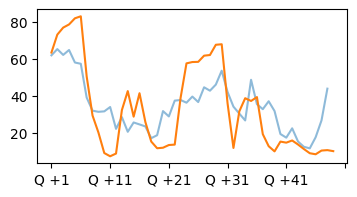

In [26]:
fig, ax = plt.subplots(figsize=(4,2))
wb_scenarios = simulator.scenario.get_scenarios(t_now, 'discharge').copy()
wb_scenarios.iloc[:,:-1].T.plot(legend=False, alpha=0.5, ax=ax)
ax.plot(range(0,49), obs_data.discharge.shift(-1).loc[t_now:t_now+pd.DateOffset(hours=48)])

In [27]:
logfile = str((simulator.savepath_timesteps / f'{t_now.strftime("%Y-%m-%d")}.log').resolve())

In [48]:
problem = NZKProblem(
    optimization_data=data_dict,
    optimization_settings=optimization_settings,
    tree_classes=tree_classes,
    pred_hor=48,
    logfile=logfile
)

In [49]:
problem.make_model()

In [25]:
# problem.model.pprint()

In [50]:
model = problem.solve(verbose=True)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2398474
Academic license - for non-commercial use only - registered to t.j.t.vanderheijden-2@tudelft.nl
Read LP format model from file C:\Users\Heijden\AppData\Local\Temp\tmpcqkb5h54.pyomo.lp
Reading time = 0.00 seconds
x337: 342 rows, 337 columns, 773 nonzeros
Set parameter NonConvex to value 2
Set parameter MIPGap to value 0.01
Set parameter MIPGapAbs to value 7.6167263310229268e-03
Set parameter TimeLimit to value 900
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license - for non-commercial use only - registered to t.j.t.vanderheijden-2@tudelft.nl
Optimize a model with 342 rows, 337 columns and 773 nonzeros
Model fingerprint: 0x294e36eb
Model has 143 quadratic objective terms
Model has 235 quadratic constraints
Variable t

In [ ]:
log_infeasible_constraints(model, log_expression=True, log_variables=True)
logging.basicConfig(filename='debug_log.log', encoding='utf-8', level=logging.INFO)

In [51]:
results = problem.get_results()

In [53]:
results

In [54]:
simulator.simulate_timestep(t_now, results)

In [33]:
simulator.run_simulation()

Running simulation from 2019-01-15 03:00:00+01:00
Refitting IDM BN


  2%|▏         | 9/405 [00:51<26:23,  4.00s/it]  

Refitting IDM BN


 11%|█         | 45/405 [03:28<19:40,  3.28s/it]  

    containing a solution


 44%|████▍     | 178/405 [32:36<02:06,  1.80it/s]   

Refitting IDM BN


 86%|████████▌ | 347/405 [36:35<01:34,  1.62s/it]

Refitting IDM BN


100%|██████████| 405/405 [37:41<00:00,  5.58s/it]


In [88]:
simulation_df = simulator.simulation_data.copy()
simulation_df.iloc[653:]

,h_nzk,Q_gate,Q_pump,Q_wb,Q_ark,E_act,E_dam,h_ns,p_dam,p_idm
2019-01-28 15:00:00+01:00,-0.3964,0,0,92.74,45.08,0.0,0.309372,-0.085,47.4,49.66
2019-01-28 16:00:00+01:00,-0.3952,0,0,80.7,40.15,0.0,0.314845,-0.215,51.74,53.14
2019-01-28 17:00:00+01:00,-0.3942,0,0,54.12,44.39,0.0,0.206333,-0.382,62.0,61.19
2019-01-28 18:00:00+01:00,-0.3934,0,0,42.74,42.14,0.0,0.259169,-0.423,59.9,64.0
2019-01-28 19:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,0.258379,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2019-01-31 19:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-31 20:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-31 21:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-31 22:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
simulation_df.loc[t_now, ['Q_gate', 'Q_pump', 'E_act']] = 0.0
wl_ns = np.round(problem.optimization_data['wl'][0], decimals=3) # accuracy in mm
h_nzk0 = problem.optimization_data['h_nzk'][0] # accuracy in mm
q_wb = np.round(problem.optimization_data['wb_discharge'][0], decimals=2)[0]
q_ark = np.round(problem.optimization_data['ark_discharge'][0], decimals=2)[0]
q_out = 0
q_in = q_wb + q_ark

A_nzk = 36*10e6 # m^2
dt = 3600 # s
h_nzk1 = np.round(h_nzk0 + (q_in - q_out) * dt / A_nzk, decimals=4)
h_nzk1

-0.399

In [114]:
simulation_df.loc[t_now, 'h_nzk'] = h_nzk1
simulation_df.loc[t_now, 'h_ns'] = wl_ns
simulation_df.loc[t_now, 'p_dam'] = problem.optimization_data['dam'][0].flatten()[0]
simulation_df.loc[t_now, 'p_idm'] = problem.optimization_data['idm'][0].flatten()[0]
simulation_df.loc[t_now, 'Q_wb'] = q_wb
simulation_df.loc[t_now, 'Q_ark'] = q_ark
simulation_df.loc[t_now, 'Q_gate'] = 0.0
simulation_df.loc[t_now, 'Q_pump'] = 0.0
simulation_df.loc[t_now, 'E_act'] = 0.0


In [115]:
t_now

Timestamp('2019-01-25 03:00:00+0100', tz='Europe/Amsterdam')

In [116]:
simulation_df.iloc[565:]

,h_nzk,Q_gate,Q_pump,Q_wb,Q_ark,E_act,E_dam,h_ns,p_dam,p_idm
2019-01-24 23:00:00+01:00,-0.4013,0.0,0.0,41.56,6.33,0.0,0.0,0.208,61.1,57.82
2019-01-25 00:00:00+01:00,-0.4007,0.0,0.0,45.66,13.18,0.0,0.0,0.09,64.63,64.71
2019-01-25 01:00:00+01:00,-0.4002,0.0,0.0,49.15,2.98,0.0,0.0,-0.243,60.64,58.53
2019-01-25 02:00:00+01:00,-0.3996,0.0,0.0,49.3,10.54,0.0,0.0,-0.582,57.8,56.99
2019-01-25 03:00:00+01:00,-0.399,0.0,0.0,50.25,5.34,0.0,0.0,-0.665,55.19,53.0
...,...,...,...,...,...,...,...,...,...,...
2019-01-31 19:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-31 20:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-31 21:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-31 22:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [117]:
simulator = ClosedLoopSimulation(
    savepath=optimization_datapath / exp_name,
    optimization_settings=optimization_settings,
    simulation_index=simulation_index,
    observation_dataclass=obs_data,
    scenario_dataclass=scenario_data,
    idm_scenarioclass=idm_scenarios,
    save_individual_timesteps=True,
    simulation_data=simulation_df.copy(),
    tree_classes=tree_classes,
)

In [118]:
t_now = simulation_df.loc[simulation_df.isna().any(axis=1)].index.min()
t_now

Timestamp('2019-01-25 04:00:00+0100', tz='Europe/Amsterdam')

In [119]:
data_dict = simulator.prep_opt_data(t_now, inplace=True, return_data=True)

C:\Users\Heijden\AppData\Local\Temp\ipykernel_23288\1236462654.py:91: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  idm_scenarios_df.iloc[:, -1] = 1


In [120]:
problem = NZKProblem(
    optimization_data=data_dict,
    optimization_settings=optimization_settings,
    tree_classes=tree_classes,
    pred_hor=48,
    logfile=logfile
)

In [121]:
problem.make_model()

In [ ]:
model = problem.solve(verbose=True)

In [183]:
cb_colorlist = [
        '#377eb8', '#ff7f00', '#4daf4a',
        '#f781bf', '#a65628', '#984ea3',
        '#999999', '#e41a1c', '#dede00'
    ]

def plot_nodesedges(ax, nodesedges, colorlist):
    for i, node in enumerate(nodesedges.nodes):
        domain = node.domain
        values = node.values

        parent_id = node.parent_id
        if parent_id is not None:
            parent = nodesedges.nodes[parent_id]
            domain = [parent.domain[-1]] + [d for d in domain]
            values = [parent.values[-1]] + [v for v in values]
        ax.step(domain, values, color=colorlist[i % len(colorlist)], where='post')

def plot_res(ax, var, result_nodes, colorlist):
    for i, node in enumerate(result_nodes):
        domain = node.domain
        values = node.results[var]

        parent_id = node.parent_id
        if parent_id is not None:
            parent = result_nodes[parent_id]
            domain = [parent.domain[-1]] + [d for d in domain]
            values = [parent.results[var][-1]] + [v for v in values]
        ax.step(domain, values, color=colorlist[i % len(colorlist)], where='post', linewidth=1)

def plot_results(results, problem, data_dict):
    fig, ax = plt.subplots(3, 2, figsize=(15, 7), sharex=True)
    # Inputs on the left
    plot_nodesedges(ax[0, 0], problem.nodes_edges_discharge, cb_colorlist)
    ax[0,0].set_title('Discharge scenarios')
    ax[0,0].set_ylabel('Waterboard discharge [m3/s]')

    plot_nodesedges(ax[1, 0], problem.nodes_edges_wl, cb_colorlist)
    ax[1,0].set_title('Water level scenarios')
    ax[1,0].set_ylabel('Water level [m+NAP]')


    # IDM prices
    idm_trading_indices = [t for t in data_dict['E_dam'].keys() if not np.isnan(data_dict['E_dam'][t])]
    for i in range(len(data_dict['idm'][idm_trading_indices[0]])):
        ax[2,0].step(idm_trading_indices, [data_dict['idm'][t][i] for t in idm_trading_indices], color=cb_colorlist[i % len(cb_colorlist)], where='post', linestyle='--')

    # DAM prices
    dam_trading_indices = [t for t in data_dict['E_dam'].keys() if np.isnan(data_dict['E_dam'][t])]
    for i in range(len(data_dict['dam'][dam_trading_indices[0]])):
        ax[2,0].step(dam_trading_indices, [data_dict['dam'][t][i] for t in dam_trading_indices], color=cb_colorlist[i % len(cb_colorlist)], where='post')

    ax[2,0].set_title('DAM and IDM prices')
    ax[2,0].set_ylabel('Price [€/MWh]')
    ax[2,0].set_xlabel('Time [h]')

    # Outputs on the right
    plot_res(ax[0,1], 'q_pump', results, cb_colorlist)
    ax[0,1].set_title('Pump discharge')
    ax[0,1].set_ylabel('Pump discharge [m3/s]')

    plot_res(ax[1,1], 'q_gate', results, cb_colorlist)
    ax[1,1].set_title('Gate discharge')
    ax[1,1].set_ylabel('Gate discharge [m3/s]')

    plot_res(ax[2,1], 'h_nzk', results, cb_colorlist)
    ax[2,1].set_title('Water level')
    ax[2,1].set_ylabel('Water level [m+NAP]')
    # ax[2,1].set_ylim(-0.5, -0.35)
    ax[2,1].set_xlabel('Time [h]')

    for ax_ in ax.flatten():
        ax_.set_xlim(1,48)

    fig.tight_layout()
    return fig, ax

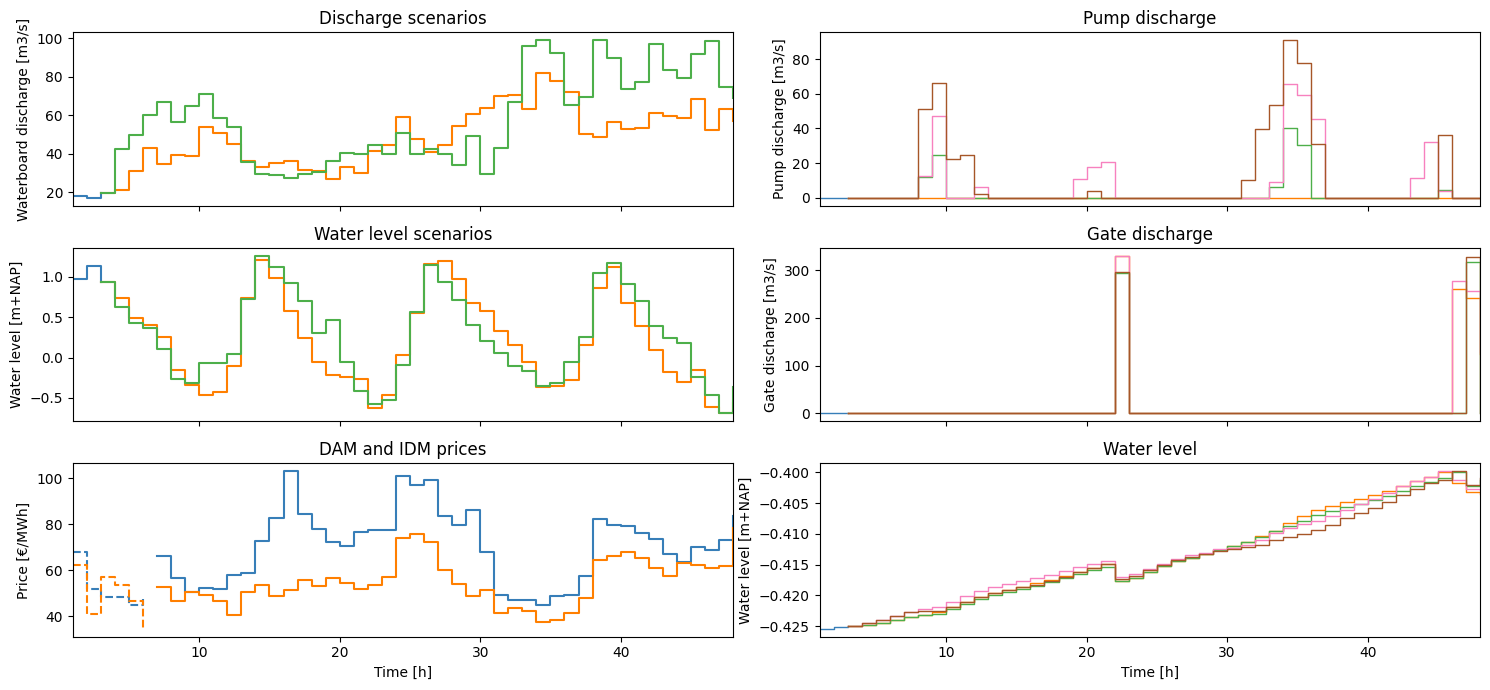

In [184]:
fig, ax = plot_results(results, problem, data_dict) # CVAR 0.9